In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
# Change this path to point to the specific run you want to analyze (e.g., 70M or 160M)
DETAILS_CSV = "wikipedia/experiments/run_20251221_192922/results/canary_details_full.csv" 
#TODO CAMBIARE
ORIGINAL_CANARIES_CSV = "memorization/canaries10rep.csv" 

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

In [66]:
def load_data(details_path, meta_path):
    if not os.path.exists(details_path) or not os.path.exists(meta_path):
        print(f"❌ ERROR: Files not found at:\n{details_path}\n{meta_path}")
        return None

    print("✅ Loading files...")
    df_details = pd.read_csv(details_path)
    df_meta = pd.read_csv(meta_path)

    # Merge to get 'type' column (High/Low Entropy)
    # We merge on 'canary_id'
    df_merged = pd.merge(df_details, df_meta[['canary_id', 'type']], on='canary_id', how='left')
    
    # Check if exact_match exists
    if 'exact_match' not in df_merged.columns:
        print("⚠️ WARNING: 'exact_match' column not found. Filling with 0.")
        df_merged['exact_match'] = 0

    print(f"Merged Data Ready: {len(df_merged)} rows.")
    return df_merged

# Execute Load
df_data = load_data(DETAILS_CSV, ORIGINAL_CANARIES_CSV)
df_data.head()

✅ Loading files...
Merged Data Ready: 1200 rows.


,epoch,canary_id,global_loss_tgt,suffix_loss_tgt,exact_match,split,suffix_loss_ref,global_loss_ref,loss_optimum,mia_score,counterfactual_score,contextual_score,type
0,0,le_f93987,7.106415,5.534177,0,validation,5.304459,6.609330,5.304459,-0.229719,-0.043307,-0.043307,low_entropy
1,0,he_2fc9c5,2.323907,2.499388,0,train,6.499841,7.593362,6.499841,4.000453,0.615469,0.615469,high_entropy
2,0,he_487620,2.257516,2.239817,0,train,7.466235,8.212183,7.178337,5.226418,0.700007,0.687976,high_entropy
3,0,le_d95996,5.124541,4.229504,0,validation,4.412335,5.371444,4.412335,0.182832,0.041437,0.041437,low_entropy
4,0,he_e6c539,1.726761,1.157728,0,train,8.359902,8.877928,7.656631,7.202174,0.861514,0.848794,high_entropy


In [67]:
def calculate_dynamic_threshold(scores, fpr_target=0.10):
    """
    Calculates the threshold at the (1-FPR) percentile of the validation scores.
    """
    if len(scores) == 0: return float('inf')
    return np.percentile(scores, (1 - fpr_target) * 100)

def analyze_subset_metrics(df_subset):
    stats = []
    epochs = sorted(df_subset['epoch'].unique())
    
    for epoch in epochs:
        df_epoch = df_subset[df_subset['epoch'] == epoch]
        
        # 1. Split Data
        val_data = df_epoch[df_epoch['split'] == 'validation']
        train_data = df_epoch[df_epoch['split'] == 'train']
        
        # Skip if missing data
        if len(val_data) == 0 or len(train_data) == 0: 
            continue
            
        # 2. Calibrate MIA Threshold using VALIDATION set (Non-members)
        # We want 10% False Positive Rate on non-members
        tau = calculate_dynamic_threshold(val_data['mia_score'].values, fpr_target=0.10)
        
        # 3. Calculate Metrics on TRAINING set (Members)
        
        # A. MIA Recall
        is_memorized = train_data['mia_score'] > tau
        mia_recall = is_memorized.sum() / len(train_data)
        
        # B. Contextual & Counterfactual (Averages)
        avg_ctx = train_data['contextual_score'].mean()
        avg_cf = train_data['counterfactual_score'].mean()
        
        # C. Exact Match (Biderman / Extractability)
        # This is the percentage of training canaries generated verbatim
        if 'exact_match' in train_data.columns:
            extractability = train_data['exact_match'].mean()
        else:
            extractability = 0.0
        
        stats.append({
            'epoch': epoch, 
            'mia_recall': mia_recall, 
            'contextual_score': avg_ctx, 
            'counterfactual_score': avg_cf,
            'extractability': extractability
        })
        
    return pd.DataFrame(stats)

In [68]:
def plot_comparison(df_stats, title):
    if df_stats.empty:
        print(f"⚠️ No data to plot for {title}")
        return

    plt.figure(figsize=(12, 7))
    
    # 1. MIA Recall (Red)
    sns.lineplot(data=df_stats, x='epoch', y='mia_recall', label='MIA Recall', 
                 linewidth=2, color='crimson', alpha=0.6)
    
    # 2. Counterfactual (Green)
    sns.lineplot(data=df_stats, x='epoch', y='counterfactual_score', label='Counterfactual', 
                 linewidth=2, linestyle='-.', color='green', alpha=0.6)
    
    # 3. Contextual (Blue - Your Main Metric)
    sns.lineplot(data=df_stats, x='epoch', y='contextual_score', label='Contextual', 
                 linewidth=3, marker='s', color='royalblue')
    
    # 4. Exact Match (Black/Purple - Biderman)
    sns.lineplot(data=df_stats, x='epoch', y='extractability', label='Exact Match', 
                 linewidth=3, marker='o', color='darkviolet')

    plt.title(title, fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Training Epochs", fontsize=14)
    plt.ylabel("Score (0.0 - 1.0)", fontsize=14)
    
    # Set limits slightly wider to see points clearly
    plt.ylim(-0.05, 1.05)
    plt.xticks(df_stats['epoch'].unique())
    
    plt.legend(loc='center right', fontsize=12, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

--- Analyzing High Entropy Canaries ---


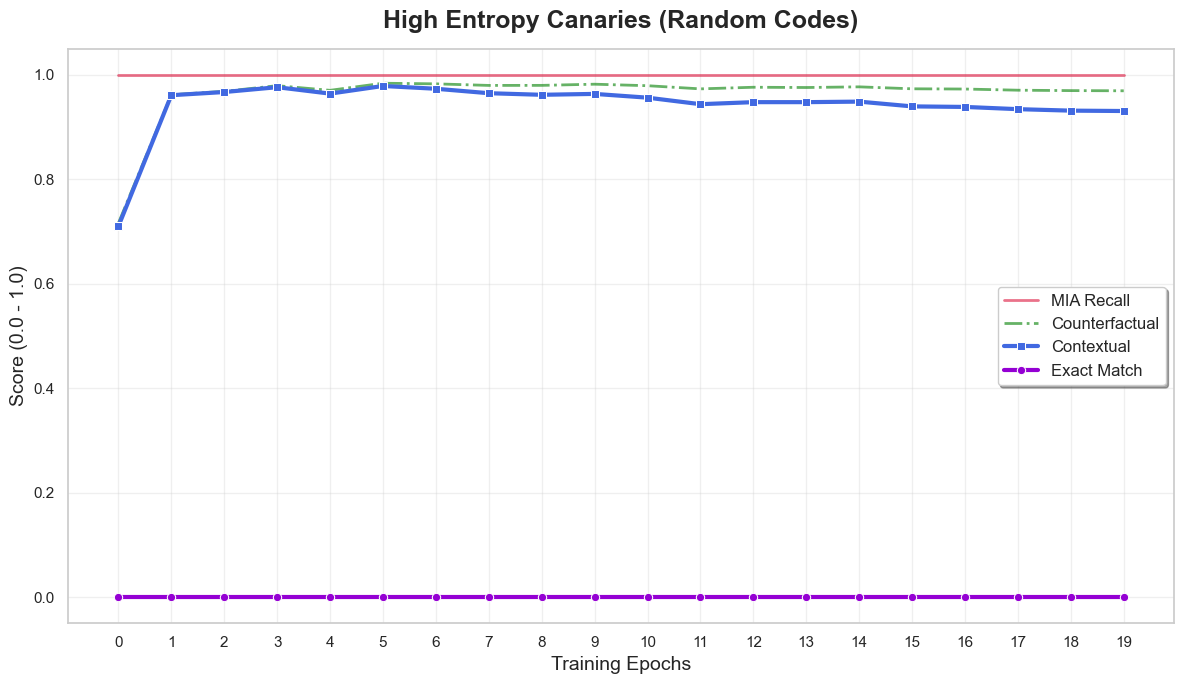

    epoch  mia_recall  contextual_score  counterfactual_score  extractability
19     19         1.0           0.93093              0.969655             0.0




In [71]:
if df_data is not None:
    # --- ANALYSIS 1: HIGH ENTROPY (Random Codes) ---
    print("--- Analyzing High Entropy Canaries ---")
    df_high = df_data[df_data['type'] == 'high_entropy']
    
    if not df_high.empty:
        stats_high = analyze_subset_metrics(df_high)
        plot_comparison(stats_high, "High Entropy Canaries (Random Codes)")
        # Optional: Print last epoch stats
        print(stats_high.tail(1))
    else:
        print("No High Entropy data found.")

    print("\n" + "="*50 + "\n")



--- Analyzing Low Entropy Canaries ---


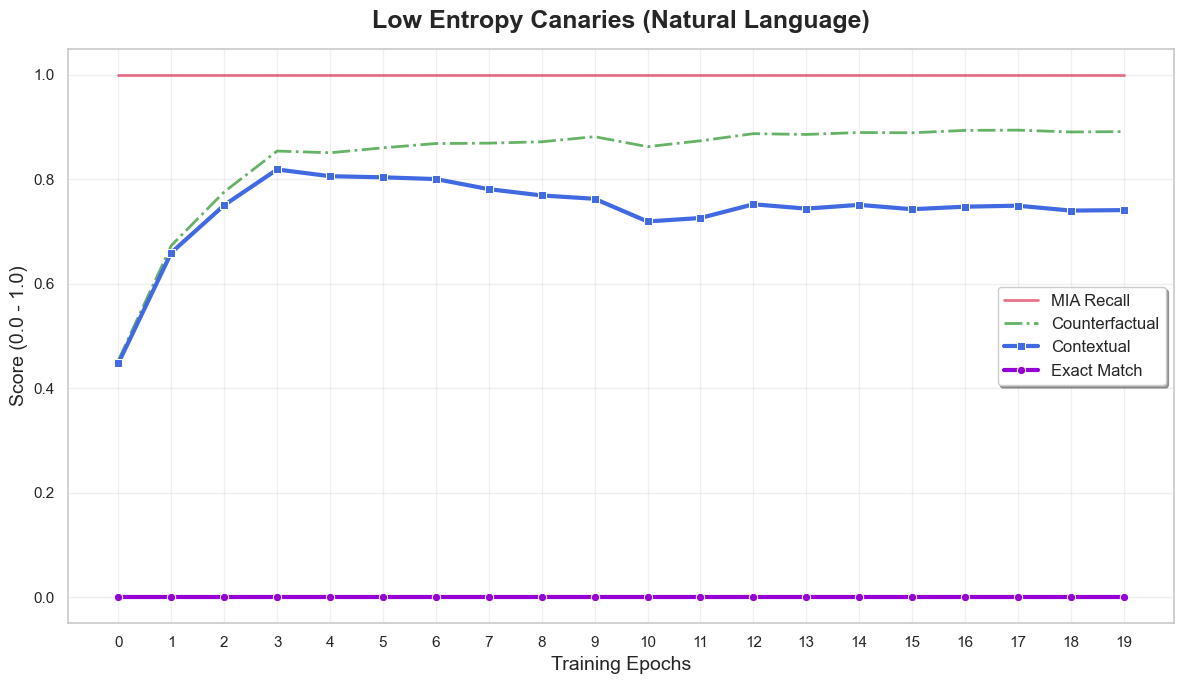

    epoch  mia_recall  contextual_score  counterfactual_score  extractability
19     19         1.0          0.741148              0.891478             0.0


In [72]:
# --- ANALYSIS 2: LOW ENTROPY (Natural Language) ---
print("--- Analyzing Low Entropy Canaries ---")
df_low = df_data[df_data['type'] == 'low_entropy']

if not df_low.empty:
    stats_low = analyze_subset_metrics(df_low)
    plot_comparison(stats_low, "Low Entropy Canaries (Natural Language)")
    # Optional: Print last epoch stats
    print(stats_low.tail(1))
else:
    print("No Low Entropy data found.")

In [ ]:
def plot_comparison_with_ppl(df_stats, title):
    if df_stats.empty:
        print(f"⚠️ No data to plot for {title}")
        return

    fig, ax1 = plt.subplots(figsize=(12, 7))

    # --- ASSE Y SINISTRO (Score 0-1) ---
    ax1.set_xlabel("Training Epochs", fontsize=14)
    ax1.set_ylabel("Score (0.0 - 1.0)", fontsize=14)
    ax1.set_ylim(-0.05, 1.05)

    # 1. MIA Recall (Red)
    sns.lineplot(data=df_stats, x='epoch', y='mia_recall', label='MIA Recall', 
                 linewidth=2, color='crimson', alpha=0.6, ax=ax1)
    
    # 2. Contextual (Blue)
    sns.lineplot(data=df_stats, x='epoch', y='contextual_score', label='Contextual (Ghosh)', 
                 linewidth=3, marker='s', color='royalblue', ax=ax1)
    
    # 3. Exact Match (Purple)
    sns.lineplot(data=df_stats, x='epoch', y='exact_match', label='Exact Match (Biderman)', 
                 linewidth=3, marker='o', color='darkviolet', ax=ax1)

    # --- ASSE Y DESTRO (Perplexity) ---
    ax2 = ax1.twinx()  # Crea un secondo asse che condivide la stessa X
    ax2.set_ylabel("Suffix Perplexity (Log Scale)", fontsize=14, color='black')
    
    # 4. Perplexity (Black Dashed)
    sns.lineplot(data=df_stats, x='epoch', y='avg_perplexity', label='Perplexity', 
                 linewidth=2, linestyle=':', color='black', marker='x', ax=ax2)
    
    # Opzionale: Scala logaritmica se la PPL esplode
    # ax2.set_yscale('log') 

    # Titolo e Legenda
    plt.title(title, fontsize=18, fontweight='bold', pad=15)
    
    # Gestione Legenda unica (un po' tricky con due assi)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', fontsize=12, frameon=True, shadow=True)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()